# CKP8366 - TÓPICOS AVANÇADOS - APRENDIZAGEM DE MÁQUINA PROBABILÍSTICA

<img  src="https://img.shields.io/badge/UFC_CKP8366-VAUX GOMES-000000?style=for-the-badge&logo=" /> <img src="https://img.shields.io/badge/Jupyter-000000?style=for-the-badge&logo=jupyter&logoColor=white" /> <img src="https://img.shields.io/badge/Python-000000?style=for-the-badge&logo=python&logoColor=white" />


In [1]:
import numpy as np
from scipy.stats import norm, multivariate_normal

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans

## Gaussian Mixture Model

In [2]:
class GaussianMixtureModel:
  def __init__(self, K, epochs=50):
    self.K = K
    self.epochs = epochs

  def fit(self, X):
    N, D = X.shape
    
    # Kmeans
    kmeans = KMeans(n_clusters=self.K, random_state=42, n_init="auto").fit(X)

    # Dirichlet
    alphas = np.ones(self.K)                    # Priors de Dirichlet
    
    # Normal Inverse Wishart (NIW)
    mu = np.mean(X, axis=0)                     # Média inicial (D x 1)
    kappa = 0.01                                # Peso da média
    nu = D + 2                                  # Graus de liberdade
    S0 = np.cov(X.T) * (1 / self.K ** (2 / D))  # Covariância inicial (D x D)
    
    # 
    means = kmeans.cluster_centers_             # K x D
    weights = np.ones(self.K) / self.K          # K x 1
    covariances = np.array([np.eye(D) * 1 / 
                   self.K ** (2 / N)] * self.K) # K x D x D
    
    #
    likelihoods = np.empty(self.epochs)

    # EM
    for e in range(self.epochs):
      # Expectation: calcular responsabilidades
      responsibilities = np.empty((N, self.K))
      
      for k in range(self.K):
        responsibilities[:, k] = weights[k] * multivariate_normal.pdf(X, mean=means[k], cov=covariances[k])
          
      # Normalizar responsabilidades
      responsibilities /= responsibilities.sum(axis=1, keepdims=True)

      # M-Step: atualizar parâmetros
      responsibilities_sum = responsibilities.sum(axis=0)

      # Atualizar pesos (π)
      weights = (alphas - 1 + responsibilities_sum) / (N + np.sum(alphas) - self.K)

      # Atualizar médias
      for k in range(self.K):
          weighted_sum = np.sum(responsibilities[:, k][:, np.newaxis] * X, axis=0)
          means[k] = (kappa * mu + weighted_sum) / (kappa + responsibilities_sum[k])

      # Atualizar covariâncias
      for k in range(self.K):
          diff = X - means[k]
          weighted_cov = np.einsum("ni,nj->ij", responsibilities[:, k][:, np.newaxis] * diff, diff) #
          covariances[k] = (S0 + weighted_cov) / (responsibilities_sum[k] + nu + D + 2)
      
      # Log-Likelihood
      likelihoods[e] = 0
      
      for i in range(N):
        k = np.argmax(responsibilities[i])
        likelihoods[e] += np.log(weights[k] * multivariate_normal.pdf(X[i], mean=means[k], cov=covariances[k]))
       
    # Output
    self.weights = weights  
    self.means = means
    self.covariances = covariances
    
    self.likelihoods = likelihoods
    self.bic = self.__bic(self.K * (D + 2) + D**2, N) # M número de parâmetros ajustáveis (means, covariances, weights)
    self.aic = self.__aic(self.K * (D + 2) + D**2)
    
  def predict(self, X):
    # Hard clusters
    return np.argmax(self.predict_proba(X), axis=1)
    
  def predict_proba(self, X):
    # Soft clusters
    N = X.shape[0]

    # Responsibility of x_i
    responsibilities = np.empty((N, self.K))
    for k in range(self.K):
      responsibilities[:, k] = self.weights[k] * multivariate_normal.pdf(X, mean=self.means[k], cov=self.covariances[k])

    return responsibilities   

  def __bic(self, M, N):
    return self.likelihoods - ((M * np.log(N)) / 2)
  
  def __aic(self, M):
    return self.likelihoods - M
  
  def __str__(self):
      return f"GaussianMixtureModel: \n(K → {self.K})(Epochs → {self.epochs})"

#### Carregamento dos dados

In [3]:
# Data
X = np.genfromtxt('./files/clustering_data.csv', delimiter=',')
X = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0)) # Normalization 0 ~ 1

#### Training

In [13]:
def run(X, K, epochs):
  metrics = np.empty((K, 3))
  models = []
  
  for k in range(1, K + 1):
    # Training
    gmm = GaussianMixtureModel(k, epochs=epochs)
    gmm.fit(X)
    
    # Metrics
    metrics[k - 1, :] = np.array([
      gmm.likelihoods[-1],
      gmm.bic[-1],
      gmm.aic[-1] 
    ])
    
    #
    models.append(gmm)
    
  return models, metrics
    
#
%time models, metrics = run(X, 15, 50) 
  

CPU times: user 18.3 s, sys: 7.16 s, total: 25.4 s
Wall time: 8.34 s


### Plots

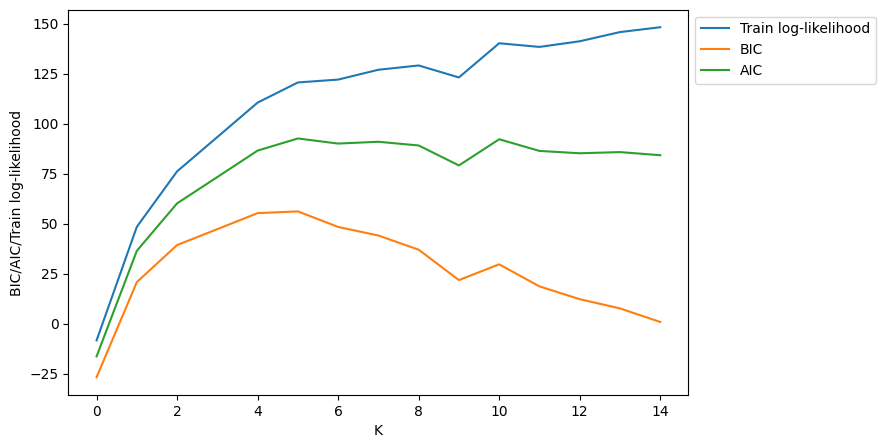

In [15]:
plt.figure(figsize=((8, 5)))

#
plt.plot(metrics[:, 0], label='Train log-likelihood')
plt.plot(metrics[:, 1], label='BIC')
plt.plot(metrics[:, 2], label='AIC')

#
plt.xlabel('K')
plt.ylabel('BIC/AIC/Train log-likelihood')
plt.legend(bbox_to_anchor=(1, 1), loc="upper left")
plt.show()

> Escolhi o valor `K = 5`, mas `K = 6` ficou muito bom também.

### Best Model

In [26]:
gmm_bic = GaussianMixtureModel(5, epochs=50)
gmm_bic.fit(X)

gmm_aic = GaussianMixtureModel(6, epochs=50)
gmm_aic.fit(X)

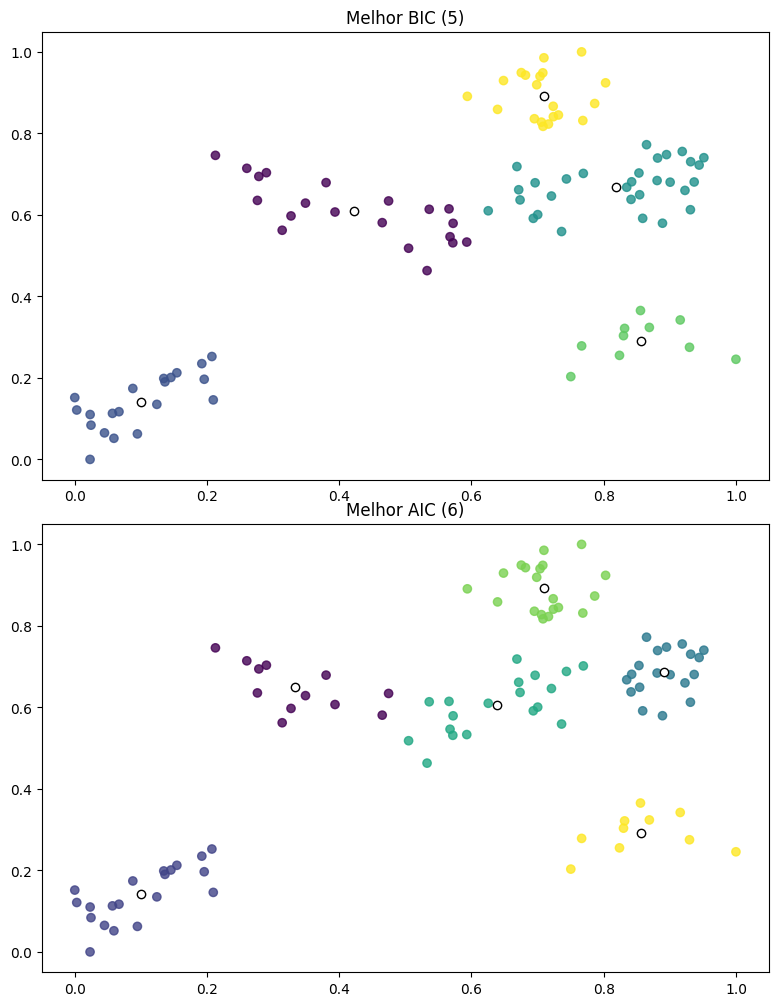

In [34]:
fig, axs = plt.subplots(2, 1, figsize=(8,10))
fig.tight_layout()

axs[0].scatter(X[:,0],X[:,1], c=gmm_bic.predict(X), alpha=0.8)
axs[0].scatter(gmm_bic.means[:,0], gmm_bic.means[:,1], color='white', edgecolors='black')
axs[0].set(title='Melhor BIC (5)')

axs[1].scatter(X[:,0],X[:,1], c=gmm_aic.predict(X), alpha=0.8)
axs[1].scatter(gmm_aic.means[:,0], gmm_aic.means[:,1], color='white', edgecolors='black')
axs[1].set(title='Melhor AIC (6)')
       
plt.grid(False)
plt.show()